In [15]:
# python notebook for Make Your Own Neural Network
# code for a 3-layer neural network, and code for learning the MNIST dataset
# (c) Tariq Rashid, 2016
# license is GPLv2

In [4]:
import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
# library for plotting arrays
# ensure the plots are inside this notebook, not an external window
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy.interpolate import griddata


%matplotlib inline

In [5]:
# neural network class definition
class neuralNetwork:
    
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc 
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass

    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors) 
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass

    
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [6]:
# # number of input, hidden and output nodes
# input_nodes = 784
# hidden_nodes = 200
# output_nodes = 10

# # learning rate
# learning_rate = 0.15

def trainandtest(input_nodes,hidden_nodes,output_nodes,learning_rate,epochs):
    # create instance of neural network
    n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)
    # load the mnist training data CSV file into a list
    training_data_file = open("mnist_dataset/mnist_train_100.csv", 'r')
    training_data_list = training_data_file.readlines()
    training_data_file.close()
    # train the neural network

    # epochs is the number of times the training data set is used for training
    epochs = epochs

    for e in range(epochs):
        # go through all records in the training data set
        for record in training_data_list:
            # split the record by the ',' commas
            all_values = record.split(',')
            # scale and shift the inputs
            inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
            # create the target output values (all 0.01, except the desired label which is 0.99)
            targets = numpy.zeros(output_nodes) + 0.01
            # all_values[0] is the target label for this record
            targets[int(all_values[0])] = 0.99
            n.train(inputs, targets)
            pass
        pass
    # load the mnist test data CSV file into a list
    test_data_file = open("mnist_dataset/mnist_test_10.csv", 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()
    # test the neural network

    # scorecard for how well the network performs, initially empty
    scorecard = []

    # go through all the records in the test data set
    for record in test_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # correct answer is first value
        correct_label = int(all_values[0])
        # scale and shift the inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # query the network
        outputs = n.query(inputs)
        # the index of the highest value corresponds to the label
        label = numpy.argmax(outputs)
        # append correct or incorrect to list
        if (label == correct_label):
            # network's answer matches correct answer, add 1 to scorecard
            scorecard.append(1)
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            scorecard.append(0)
            pass
        
        pass
    # calculate the performance score, the fraction of correct answers
    scorecard_array = numpy.asarray(scorecard)
    performance = scorecard_array.sum() / scorecard_array.size
    print ("performance = ", performance )
    return performance



In [11]:
def Performance(input_nodes,hidden_nodes,output_nodes,learning_rate_list,epochs_list):
    performance_list = []
    for learning_rate in learning_rate_list:
        for epochs in epochs_list:
            performance_list.append(trainandtest(input_nodes,hidden_nodes,output_nodes,learning_rate,epochs))
    return performance_list
def ShowPic(learning_rate_list,epochs_list,performance_list):
    #三维曲线图
    xt = learning_rate_list
    yt = epochs_list

    #meshgrid时后遍历的参数在前，先遍历的参数在后
    yt,xt = np.meshgrid(yt,xt)
    #zt变成（外循环长度，内循环长度）的二维数组
    zt = np.array(performance_list).reshape(20,10)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xt, yt, zt, cmap='rainbow',
                        linewidth=0, antialiased=False)
    
    # # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()

In [12]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
# learning_rate = 0.15
learning_rate_list = numpy.arange(0.05,1.05,0.05)
epochs_list = np.array([1,2,3,4,5,6,7,8,9,10])

performance_list = Performance(input_nodes,hidden_nodes,output_nodes,learning_rate_list,epochs_list)


performance =  0.4
performance =  0.5
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.7
performance =  0.6
performance =  0.6
performance =  0.7
performance =  0.5
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.7
performance =  0.7
performance =  0.7
performance =  0.6
performance =  0.7
performance =  0.7
performance =  0.5
performance =  0.6
performance =  0.6
performance =  0.7
performance =  0.7
performance =  0.7
performance =  0.7
performance =  0.6
performance =  0.6
performance =  0.7
performance =  0.6
performance =  0.6
performance =  0.6
performance =  0.7
performance =  0.7
performance =  0.7
performance =  0.6
performance =  0.6
performance =  0.7
performance =  0.7
performance =  0.6
performance =  0.6
performance 

C:\Users\90454\AppData\Local\Temp\ipykernel_21168\2003697124.py:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


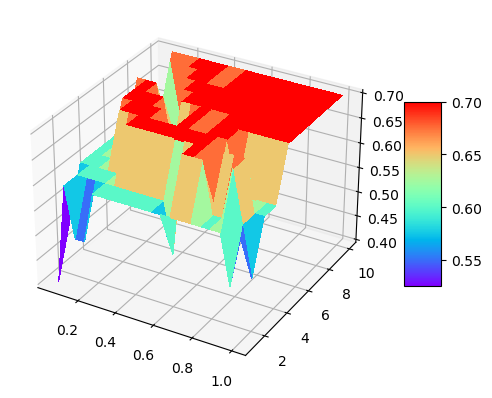

In [13]:
ShowPic(learning_rate_list,epochs_list,performance_list)